#<h1><font color="#110068" size=5> TFE</font></h1>


<h1><font color="#110068" size=6>Modelo de redes convolucionales para la detección de Patologías oculares mediante el procesamiento de imágenes </font></h1>

<div style="text-align: right">
<font size=3> </font><br>
ALUMNO 1: Margarita Cardenas  </font><br>
ALUMNO 2: Miguel Rojas </font><br>
ALUMNO 3: Walter Vega </font><br>

</font><br>
<font size=3>TFE:
Implementar una Inteligencia Artificial para la detección de patologías oculares mediante el procesamiento de imágenes
</font><br>
<font size=3>UNIR</font>
</div>

# Instalación de complementos y librerias necesarias

In [1]:
#!pip install pandas
!pip install tensorflow

## Descargamos el dataset de imágenes (Desde una carpeta compartida en GoogleDrive) y descomprimimos el conjunto de imágenes con los que vamos a trabajar

In [2]:
import os

from pydrive2.auth import GoogleAuth
from google.colab import drive as colab_drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# Autenticar el usuario
auth.authenticate_user()

# Inicializar GoogleAuth y establecer las credenciales
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

# Crear la instancia de GoogleDrive
drive = GoogleDrive(gauth)

file_id = '1KXCIri7VEdjwCnTPocehAf73z_7jgbgF'

if (not os.path.exists("/content/DS_TFE_final.zip")):
  download = drive.CreateFile({'id': file_id})
  # Download the file to a local disc
  download.GetContentFile('DS_TFE_final.zip')
  !unzip "/content/DS_TFE_final.zip"


Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR273.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR274.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR275.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR277.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR278.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR280.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR281.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR282.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR283.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR286.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR288.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR289.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR29.jpg  
  inflating: DS_TFE_Final/train/Diabetic_Retinopathy/DR290.jpg  
  inflating: DS_TFE_Final/trai

# Importamos las librerias necesarias para los experimentos

In [3]:
import pandas
import numpy as np
import os
import tensorflow as tf
import cv2
import glob
import matplotlib.pyplot as plt

from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



Carga de las variables con los directores donde se encuentran las imágenes de entrenamiento, validación y prueba

In [5]:
train_dir = '/content/DS_TFE_Final/train'
test_dir = '/content/DS_TFE_Final/test'
val_dir = '/content/DS_TFE_Final/val'

Chequeo de cantidad de imágenes cargadas en cada directorio.

In [6]:
cataract_images = glob.glob(train_dir+"/Cataract/*.jpg")
diabetic_retinopathy_images = glob.glob(train_dir+"/Diabetic_Retinopathy/*.jpg")
glaucoma_images = glob.glob(train_dir+"/Glaucoma/*.jpg")
healthy_images = glob.glob(train_dir+"/Healthy/*.jpg")
macular_scar_images = glob.glob(train_dir+"/Macular_Scar/*.jpg")
myopia_images = glob.glob(train_dir+"/Myopia/*.jpg")

print(len(cataract_images))
print(len(diabetic_retinopathy_images))
print(len(glaucoma_images))
print(len(healthy_images))
print(len(macular_scar_images))
print(len(myopia_images))

732
1056
944
717
933
1050


## Generamos un grafico de torta para ver la cantidad de imagenes

De esta forma se puede observar la distribución de clases y el balanceo de clases.

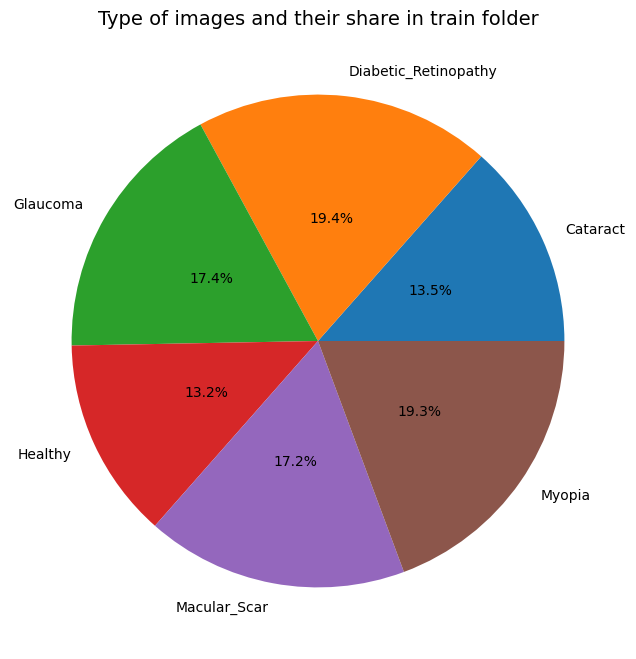

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.pie(x=np.array([len(cataract_images), len(diabetic_retinopathy_images),
                    len(glaucoma_images),len(healthy_images), len(macular_scar_images),
                    len(myopia_images)
                    ]), autopct="%.1f%%", labels=["Cataract", "Diabetic_Retinopathy", "Glaucoma", "Healthy",
                                                  "Macular_Scar", "Myopia"], pctdistance=0.5)
plt.title("Type of images and their share in train folder", fontsize=14);

## Creación de los generadores de imágenes mediante el objeto ImageDataGenerator

Este objeto permite procesar batches con una cantidad determinada de imágenes con normalización X/255, desde los directorios definidos anteriormente.

El batch definido es de 20 y al tratarse de un algoritmo de clasificación multiclase se utiliza el parámetro class_mode como categorical.

Adicionalmente se define el tamaño de las imagenes a procesar como (224,224)

El input_shape para el modelo indica el largo y ancho de las imagenes así como también la cantidad de dimensiones.
En este caso se ajusta a los modelos pre entrenados donde la mayoría acepta tamaños de 224,224 de 3 dimensiones (correspondiente a los canales RGB)
En algunas de las redes esta variable se debe redefinir para el tamaño correcto para diche red preentrenada



In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)


train_generator = train_datagen.flow_from_directory(train_dir, batch_size=20, class_mode='categorical', target_size = (224, 224))
validation_generator = val_datagen.flow_from_directory(val_dir, shuffle=False, batch_size=20, class_mode = 'categorical', target_size=(224, 224))
test_generator = test_datagen.flow_from_directory(test_dir, batch_size=20, class_mode = 'categorical', target_size=(224, 224))

Found 5432 images belonging to 6 classes.
Found 775 images belonging to 6 classes.
Found 1554 images belonging to 6 classes.


In [9]:
input_shape = (224, 224, 3)

## Preparamos la configuración para todos los graficos que vamos a utilizar

La siguiente función permite graficar los valores de accuracy, perdida, recall y auc

In [10]:
def graph(h):
    accuracy = h.history['accuracy']
    val_accuracy  = h.history['val_accuracy']

    loss = h.history['loss']
    val_loss = h.history['val_loss']

    precision = h.history['precision']
    val_precision = h.history['val_precision']

    recall = h.history['recall']
    val_recall = h.history['val_recall']

    auc = h.history['auc']
    val_auc = h.history['val_auc']

    plt.figure(figsize=(12,12))

    plt.subplot(4, 4, 1)
    plt.plot(accuracy, label = "Training accuracy")
    plt.plot(val_accuracy, label="Validation accuracy")
    plt.ylim(0, 1)
    plt.legend()
    plt.title("Training vs validation accuracy")


    plt.subplot(4,4,2)
    plt.plot(loss, label = "Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation loss")

    plt.subplot(4,4,3)
    plt.plot(precision, label = "Training Precisión")
    plt.plot(val_precision, label="Validation Precisión")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Precisión")

    plt.subplot(4,4,4)
    plt.plot(recall, label = "Training Recall")
    plt.plot(val_recall, label="Validation Recall")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation Recall")

    plt.show()

    plt.figure(figsize=(12,12))

    plt.subplot(4,4,1)
    plt.plot(auc, label = "Training auc")
    plt.plot(val_auc, label="Validation auc")
    plt.ylim(0, 1.05)
    plt.legend()
    plt.title("Training vs validation auc")

    plt.show()

La siguiente función permite visualizar la matriz de confusión de una forma visualmente amigable

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
def cf_matrix(y_pred_test, y_test, y_pred_val, y_val):
  y_true_test = y_test
  y_pred_test_classes = np.argmax(y_pred_test, axis=1)

  y_true_val = y_val
  y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Create a confusion matrix
  cm_test = confusion_matrix(y_test, y_pred_test_classes)
  cm_val = confusion_matrix(y_val, y_pred_val_classes)
  Etq = ["Cataract", "D_Retinopathy", "Glaucoma", "Healthy", "M_Scar", "Myopia"]

# Plot the confusion matrix
  plt.rcParams["figure.figsize"] = [9.50, 4.50]
  plt.rcParams["figure.autolayout"] = True

  fig, (ax1, ax2) = plt.subplots(ncols=2)
  fig.subplots_adjust(wspace=0.01)
  ax1.set_title('Confusion Matrix - Test')
  sns.heatmap(cm_test, annot=True,fmt='d', cmap='YlGnBu', ax=ax1, xticklabels=Etq, yticklabels=Etq)
  ax2.set_title('Confusion Matrix - Val')
  sns.heatmap(cm_val, annot=True,fmt='d', cmap='YlGnBu', ax=ax2, xticklabels=Etq, yticklabels=Etq)

  fig.subplots_adjust(wspace=1)
  ax1.set_xlabel('Predicción')
  ax2.set_xlabel('Predicción')
  ax1.set_ylabel('Real')
  ax2.set_ylabel('Real')
  plt.show()

La siguiente función permite calcular las métricas del modelo en función de los datos reales y las predicciones.

In [13]:
from sklearn.metrics import classification_report
def calcular_metricas_por_clase(y_pred, y):
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Generar el reporte de clasificación
    reporte = classification_report(y, y_pred_classes)
    return reporte



La siguiente función permite evaluar el modelo utilizando el método evaluate propio de la librería

In [14]:
def evaluar_modelo(modelo):
  print("Evaluar con Entrenamiento:")
  modelo.evaluate(train_generator)
  print("Evaluar con Validación:")
  modelo.evaluate(test_generator)
  print("Evaluar con Prueba:")
  modelo.evaluate(validation_generator)

# Definición de Modelos

## Modelo 1

In [ ]:
# Cargar DenseNet201 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model1 = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model1.layers:
    layer.trainable = False

model1 = Sequential()
model1.add(base_model1)
model1.add(GlobalAveragePooling2D())
model1.add(Dense(128, activation = 'relu'))
model1.add(Dense(6, activation='softmax'))


# Compilar el modelo
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history1 = model1.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

74836368/74836368 [==============================] - 1s 0us/step
Epoch 1/20
100/100 [==============================] - 110s 889ms/step - loss: 1.1119 - accuracy: 0.5750 - precision: 0.7458 - recall: 0.3815 - auc: 0.8732 - val_loss: 0.9208 - val_accuracy: 0.6332 - val_precision: 0.7197 - val_recall: 0.5386 - val_auc: 0.9154
Epoch 2/20
100/100 [==============================] - 78s 787ms/step - loss: 0.8126 - accuracy: 0.6825 - precision: 0.7741 - recall: 0.5620 - auc: 0.9338 - val_loss: 0.6775 - val_accuracy: 0.7387 - val_precision: 0.8245 - val_recall: 0.6287 - val_auc: 0.9551
Epoch 3/20
100/100 [==============================] - 81s 811ms/step - loss: 0.7778 - accuracy: 0.7000 - precision: 0.7798 - recall: 0.6020 - auc: 0.9388 - val_loss: 0.6444 - val_accuracy: 0.7606 - val_precision: 0.8308 - val_recall: 0.6667 - val_auc: 0.9587
Epoch 4/20
100/100 [==============================] - 81s 808ms/step - loss: 0.7010 - accuracy: 0.7165 - precision: 0.7927 - recall: 0.6310 - auc: 0.9503 - v

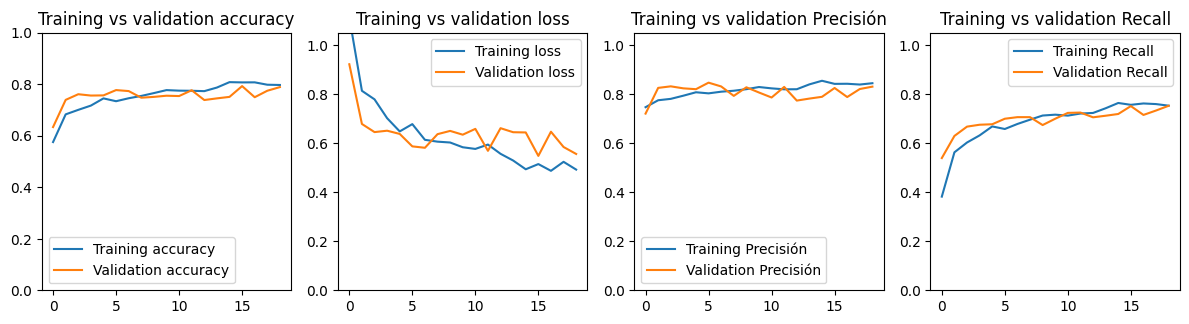

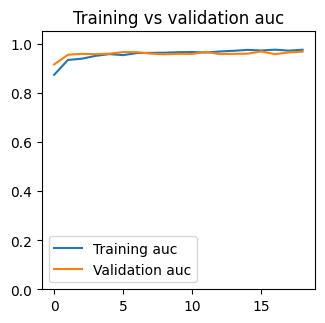

In [ ]:
graph(history1)

39/39 [==============================] - 18s 463ms/step


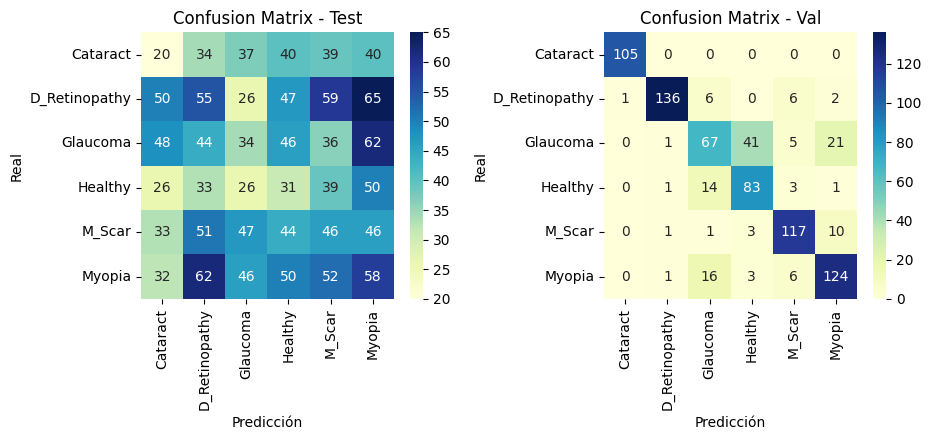

In [ ]:
y_pred1_test = model1.predict(test_generator)
y_pred1_val = model1.predict(validation_generator)
cf_matrix(y_pred1_test, test_generator.classes, y_pred1_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred1_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred1_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.10      0.10      0.10       210
           1       0.20      0.18      0.19       302
           2       0.16      0.13      0.14       270
           3       0.12      0.15      0.13       205
           4       0.17      0.17      0.17       267
           5       0.18      0.19      0.19       300

    accuracy                           0.16      1554
   macro avg       0.15      0.15      0.15      1554
weighted avg       0.16      0.16      0.16      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.97      0.90      0.93       151
           2       0.64      0.50      0.56       135
           3       0.64      0.81      0.72       102
           4       0.85      0.89      0.87       132
           5       0.78      0.83      0.81       150

    accuracy                           0.82       775
   macro avg       0.81

## Modelo 4

In [15]:
base_model4 = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model4.layers:
    layer.trainable = False


model4 = Sequential()
model4.add(base_model4)
model4.add(GlobalAveragePooling2D())
model4.add(Dense(256, activation = 'relu'))
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(6, activation='softmax'))
model4.summary()

model4.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history4 = model4.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback) #

74836368/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               491776    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 18847430 (71.90 MB)
Trainable params: 52544

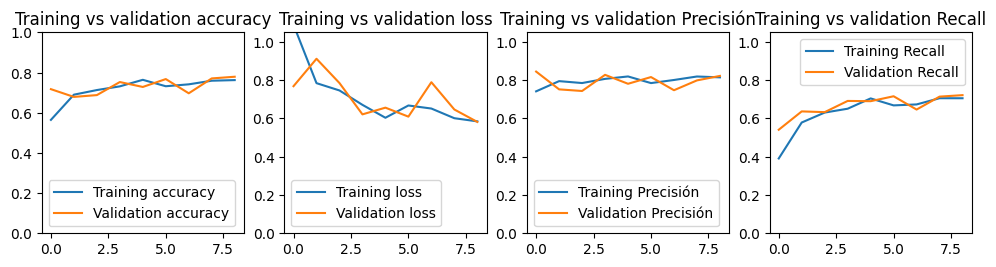

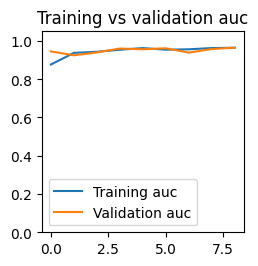

In [16]:
graph(history4)

In [17]:
y_pred4_test = model4.predict(test_generator)
y_pred4_val = model4.predict(validation_generator)

39/39 [==============================] - 19s 487ms/step


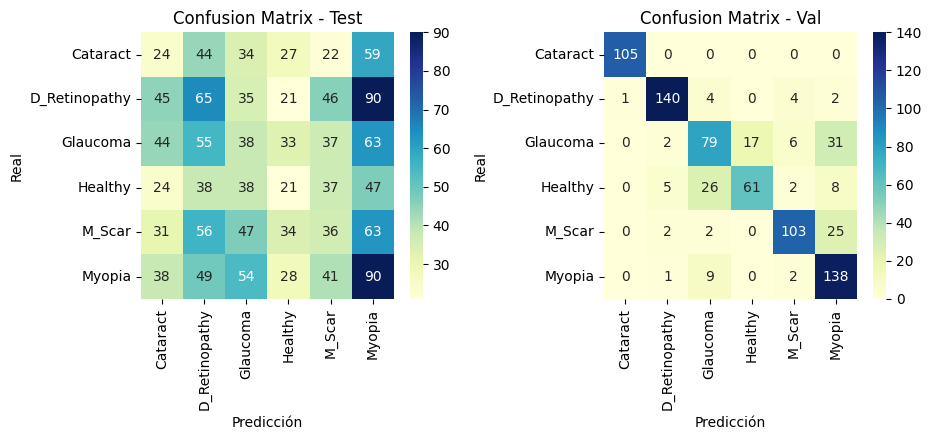

In [18]:
cf_matrix(y_pred4_test, test_generator.classes, y_pred4_val, validation_generator.classes)

In [20]:
reporte = calcular_metricas_por_clase(y_pred4_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred4_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.12      0.11      0.12       210
           1       0.21      0.22      0.21       302
           2       0.15      0.14      0.15       270
           3       0.13      0.10      0.11       205
           4       0.16      0.13      0.15       267
           5       0.22      0.30      0.25       300

    accuracy                           0.18      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.18      0.17      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.93      0.93      0.93       151
           2       0.66      0.59      0.62       135
           3       0.78      0.60      0.68       102
           4       0.88      0.78      0.83       132
           5       0.68      0.92      0.78       150

    accuracy                           0.81       775
   macro avg       0.82

## Modelo 5

In [ ]:
# Cargar DenseNet201 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model5 = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model5.layers:
    layer.trainable = False

model5 = Sequential()
model5.add(base_model5)
model5.add(GlobalAveragePooling2D())
model5.add(Dense(2056, activation = 'relu'))
model5.add(Dense(1024, activation = 'relu'))
model5.add(Dense(512, activation = 'relu'))
model5.add(Dense(256, activation = 'relu'))
model5.add(Dense(6, activation='softmax'))

# Compilar el modelo
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"),tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history5 = model5.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Epoch 1/20
100/100 [==============================] - 98s 853ms/step - loss: 1.1349 - accuracy: 0.5570 - precision: 0.7324 - recall: 0.3735 - auc: 0.8666 - val_loss: 0.8345 - val_accuracy: 0.6718 - val_precision: 0.7967 - val_recall: 0.5296 - val_auc: 0.9296
Epoch 2/20
100/100 [==============================] - 78s 778ms/step - loss: 0.8741 - accuracy: 0.6486 - precision: 0.7626 - recall: 0.5336 - auc: 0.9226 - val_loss: 0.7914 - val_accuracy: 0.6956 - val_precision: 0.7819 - val_recall: 0.5721 - val_auc: 0.9373
Epoch 3/20
100/100 [==============================] - 80s 806ms/step - loss: 0.8407 - accuracy: 0.6640 - precision: 0.7657 - recall: 0.5475 - auc: 0.9285 - val_loss: 0.9235 - val_accuracy: 0.6647 - val_precision: 0.7353 - val_recall: 0.5972 - val_auc: 0.9215
Epoch 4/20
100/100 [==============================] - 93s 936ms/step - loss: 0.8094 - accuracy: 0.6805 - precision: 0.7607 - recall: 0.5930 - auc: 0.9335 - val_loss: 0.7667 - val_accuracy: 0.7091 - val_precision: 0.8160 - v

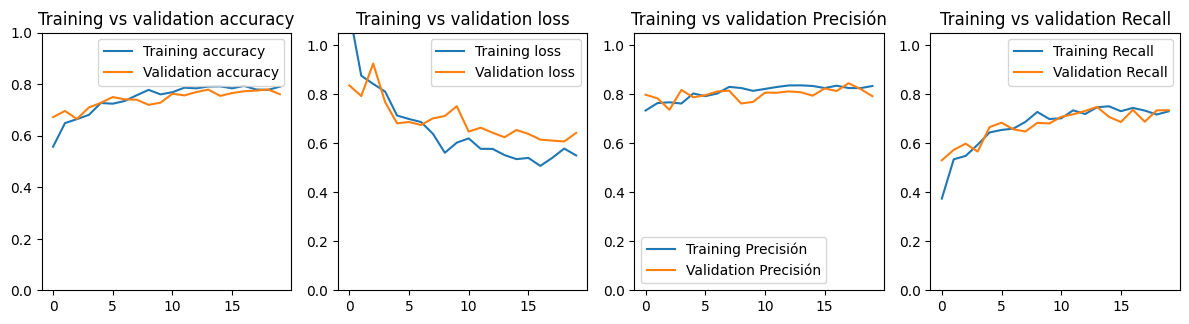

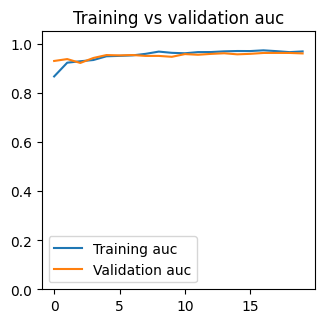

In [ ]:
graph(history5)

39/39 [==============================] - 13s 343ms/step


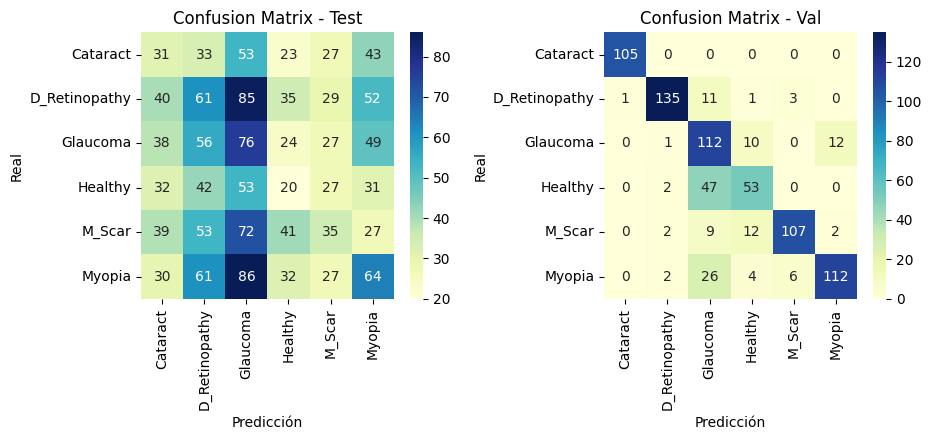

In [ ]:
y_pred5_test = model5.predict(test_generator)
y_pred5_val = model5.predict(validation_generator)
cf_matrix(y_pred5_test, test_generator.classes, y_pred5_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred5_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred5_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.15      0.15      0.15       210
           1       0.20      0.20      0.20       302
           2       0.18      0.28      0.22       270
           3       0.11      0.10      0.11       205
           4       0.20      0.13      0.16       267
           5       0.24      0.21      0.23       300

    accuracy                           0.18      1554
   macro avg       0.18      0.18      0.18      1554
weighted avg       0.19      0.18      0.18      1554

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       105
           1       0.95      0.89      0.92       151
           2       0.55      0.83      0.66       135
           3       0.66      0.52      0.58       102
           4       0.92      0.81      0.86       132
           5       0.89      0.75      0.81       150

    accuracy                           0.81       775
   macro avg       0.83

## Modelo 15

In [ ]:
# Cargar DenseNet201 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model15 = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model15.layers:
    layer.trainable = False

model15 = Sequential()
model15.add(base_model15)
model15.add(GlobalAveragePooling2D())
model15.add(Dense(2056, activation = 'relu'))
model15.add(Dense(1024, activation = 'relu'))
model15.add(Dense(512, activation = 'relu'))
model15.add(Dense(256, activation = 'relu'))
model15.add(Dense(6, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model15.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history15 = model15.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Epoch 1/25
150/150 [==============================] - 121s 730ms/step - loss: 1.0365 - accuracy: 0.5849 - precision: 0.7764 - recall: 0.3934 - auc: 0.8907 - val_loss: 0.8396 - val_accuracy: 0.6750 - val_precision: 0.7911 - val_recall: 0.5360 - val_auc: 0.9293
Epoch 2/25
150/150 [==============================] - 116s 771ms/step - loss: 0.7623 - accuracy: 0.6962 - precision: 0.7846 - recall: 0.5979 - auc: 0.9413 - val_loss: 0.7009 - val_accuracy: 0.7091 - val_precision: 0.7918 - val_recall: 0.6338 - val_auc: 0.9503
Epoch 3/25
150/150 [==============================] - 107s 711ms/step - loss: 0.6530 - accuracy: 0.7523 - precision: 0.8202 - recall: 0.6753 - auc: 0.9567 - val_loss: 0.5952 - val_accuracy: 0.7761 - val_precision: 0.8280 - val_recall: 0.7033 - val_auc: 0.9641
Epoch 4/25
150/150 [==============================] - 105s 703ms/step - loss: 0.6605 - accuracy: 0.7436 - precision: 0.7959 - recall: 0.6725 - auc: 0.9557 - val_loss: 0.7093 - val_accuracy: 0.7413 - val_precision: 0.7827

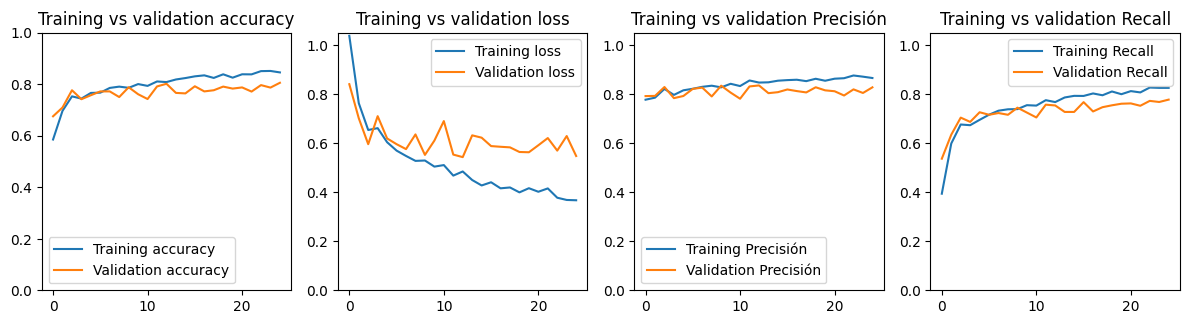

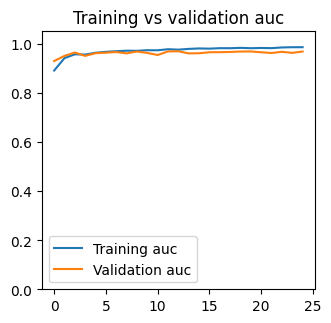

In [ ]:
graph(history15)

39/39 [==============================] - 20s 533ms/step


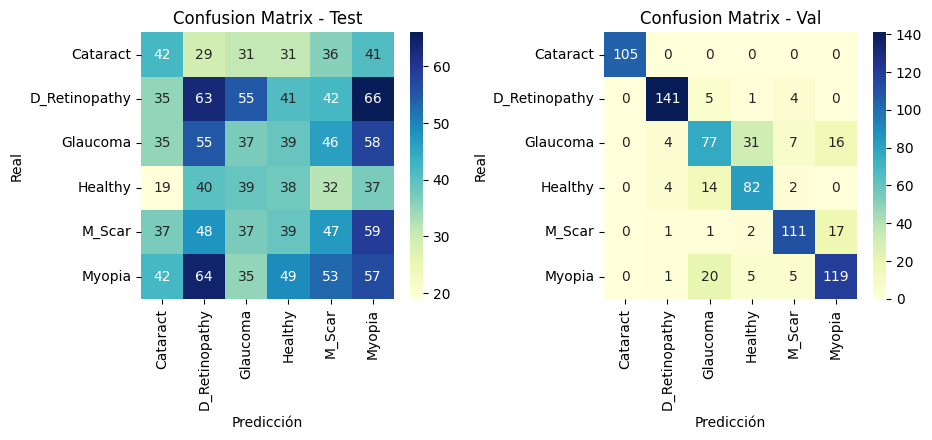

In [ ]:
y_pred15_test = model15.predict(test_generator)
y_pred15_val = model15.predict(validation_generator)
cf_matrix(y_pred15_test, test_generator.classes, y_pred15_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred15_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred15_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.20      0.20      0.20       210
           1       0.21      0.21      0.21       302
           2       0.16      0.14      0.15       270
           3       0.16      0.19      0.17       205
           4       0.18      0.18      0.18       267
           5       0.18      0.19      0.18       300

    accuracy                           0.18      1554
   macro avg       0.18      0.18      0.18      1554
weighted avg       0.18      0.18      0.18      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.93      0.93      0.93       151
           2       0.66      0.57      0.61       135
           3       0.68      0.80      0.74       102
           4       0.86      0.84      0.85       132
           5       0.78      0.79      0.79       150

    accuracy                           0.82       775
   macro avg       0.82

## Modelo 16

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

base_model16 = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model16.layers:
    layer.trainable = False


model16 = Sequential()
model16.add(base_model16)
model16.add(GlobalAveragePooling2D())
model16.add(Dense(2056, activation = 'relu'))
model16.add(Dropout(0.2))
model16.add(Dense(1024, activation = 'relu'))
model16.add(Dense(512, activation = 'relu'))
model16.add(Dropout(0.25))
model16.add(Dense(256, activation = 'relu'))
model16.add(Dense(6, activation='softmax'))
model16.summary()

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model16.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history16 = model16.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_3  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 2056)              3949576   
                                                                 
 dropout (Dropout)           (None, 2056)              0         
                                                                 
 dense_13 (Dense)            (None, 1024)              2106368   
                                                                 
 dense_14 (Dense)            (None, 512)               524800    
                                                      

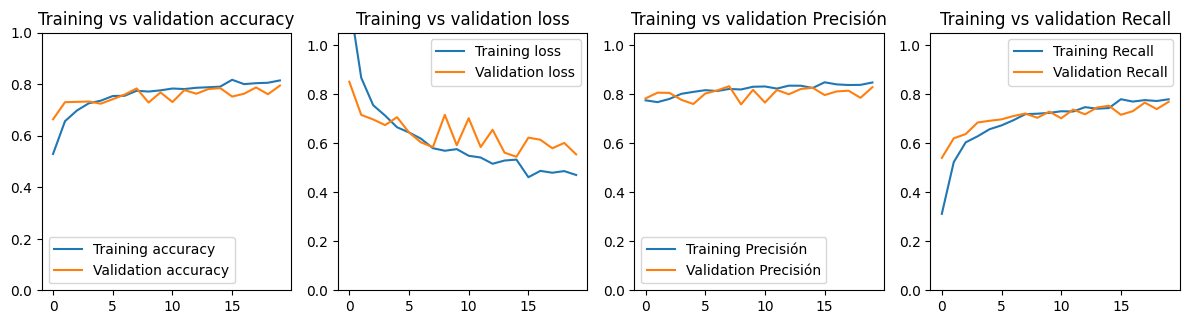

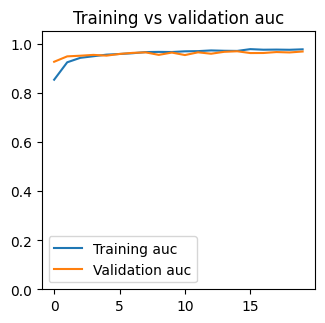

In [ ]:
graph(history16)

39/39 [==============================] - 14s 354ms/step


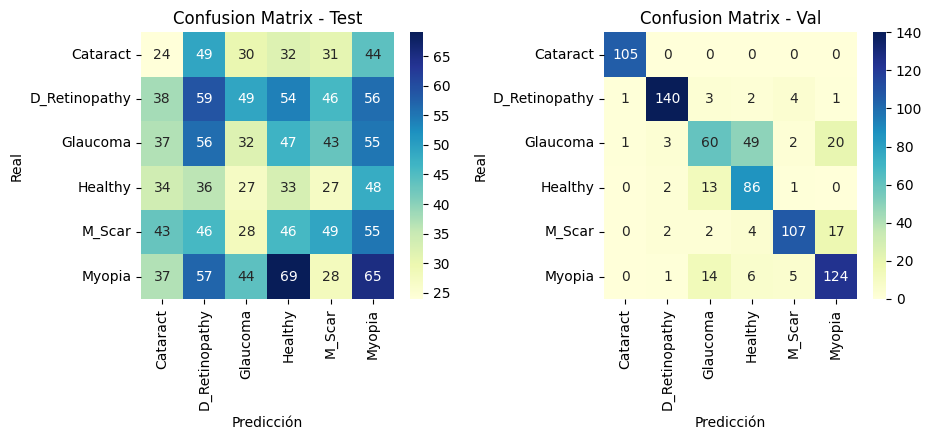

In [ ]:
y_pred16_test = model16.predict(test_generator)
y_pred16_val = model16.predict(validation_generator)
cf_matrix(y_pred16_test, test_generator.classes, y_pred16_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred16_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred16_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.11      0.11      0.11       210
           1       0.19      0.20      0.20       302
           2       0.15      0.12      0.13       270
           3       0.12      0.16      0.14       205
           4       0.22      0.18      0.20       267
           5       0.20      0.22      0.21       300

    accuracy                           0.17      1554
   macro avg       0.17      0.16      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       105
           1       0.95      0.93      0.94       151
           2       0.65      0.44      0.53       135
           3       0.59      0.84      0.69       102
           4       0.90      0.81      0.85       132
           5       0.77      0.83      0.79       150

    accuracy                           0.80       775
   macro avg       0.80

## Modelo 6

In [15]:
base_model6 = tf.keras.applications.DenseNet201(weights='imagenet', input_shape=input_shape, include_top=False)

for layer in base_model6.layers:
    layer.trainable = False


model6 = Sequential()
model6.add(base_model6)
model6.add(GlobalAveragePooling2D())
model6.add(Dense(5112, activation = 'relu'))
model6.add(Dense(2056, activation = 'relu'))
model6.add(Dense(1024, activation = 'relu'))
model6.add(Dense(512, activation = 'relu'))
model6.add(Dense(256, activation = 'relu'))
model6.add(Dense(128, activation = 'relu'))
model6.add(Dense(6, activation='softmax'))
model6.summary()

model6.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history6 = model6.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=30, callbacks=callback)

74836368/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 5112)              9820152   
                                                                 
 dense_1 (Dense)             (None, 2056)              10512328  
                                                                 
 dense_2 (Dense)             (None, 1024)              2106368   
                                                                 
 dense_3 (Dense)             (None, 512)               52

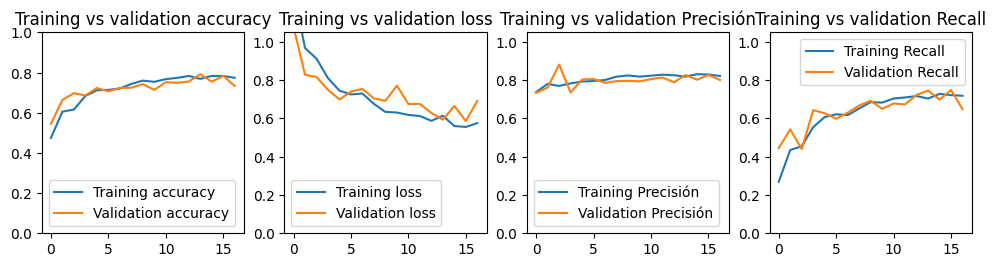

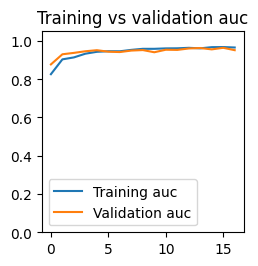

In [16]:
graph(history6)

In [17]:
y_pred6_test = model6.predict(test_generator)
y_pred6_val = model6.predict(validation_generator)

39/39 [==============================] - 18s 471ms/step


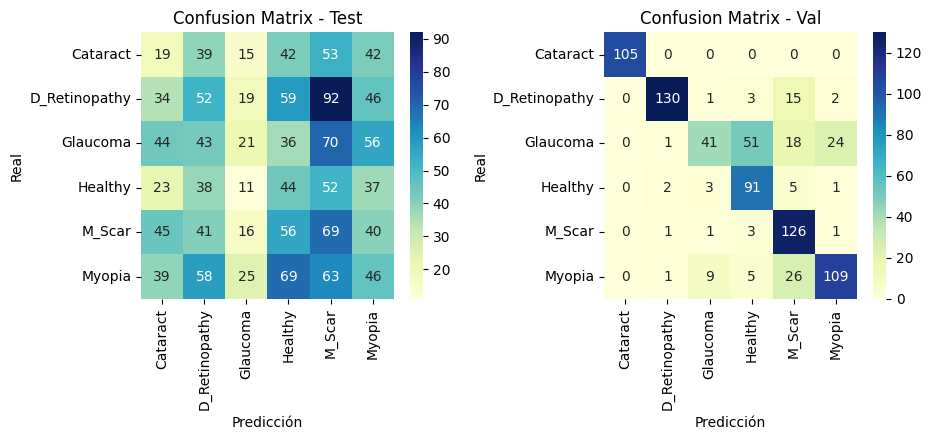

In [18]:
cf_matrix(y_pred6_test, test_generator.classes, y_pred6_val, validation_generator.classes)

In [20]:
reporte = calcular_metricas_por_clase(y_pred6_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred6_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.09      0.09      0.09       210
           1       0.19      0.17      0.18       302
           2       0.20      0.08      0.11       270
           3       0.14      0.21      0.17       205
           4       0.17      0.26      0.21       267
           5       0.17      0.15      0.16       300

    accuracy                           0.16      1554
   macro avg       0.16      0.16      0.15      1554
weighted avg       0.17      0.16      0.16      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.96      0.86      0.91       151
           2       0.75      0.30      0.43       135
           3       0.59      0.89      0.71       102
           4       0.66      0.95      0.78       132
           5       0.80      0.73      0.76       150

    accuracy                           0.78       775
   macro avg       0.79

## Modelo 20

In [ ]:
# Cargar DenseNet201 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model20 = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model20.layers:
    layer.trainable = False

# Añadir nuevas capas
x = GlobalAveragePooling2D()(base_model20.output)
x = Dense(512, activation='relu')(x)  # Añade una capa densa con 512 neuronas
predictions = Dense(6, activation='softmax')(x)  # Capa de salida para 10 clases

# Crear el modelo final
model20 = Model(inputs=base_model20.input, outputs=predictions)

# Compilar el modelo
model20.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',  metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])

# Imprimir un resumen del modelo
model20.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history_dense = model20.fit(train_generator, validation_data=test_generator, steps_per_epoch = 100, epochs=20, callbacks=callback)

Epoch 1/20
100/100 [==============================] - 121s 908ms/step - loss: 1.2467 - accuracy: 0.5150 - precision: 0.8110 - recall: 0.2295 - auc: 0.8452 - val_loss: 0.9529 - val_accuracy: 0.6557 - val_precision: 0.8389 - val_recall: 0.4022 - val_auc: 0.9182
Epoch 2/20
100/100 [==============================] - 100s 1s/step - loss: 0.9189 - accuracy: 0.6610 - precision: 0.8257 - recall: 0.4310 - auc: 0.9225 - val_loss: 0.7966 - val_accuracy: 0.7143 - val_precision: 0.8306 - val_recall: 0.5238 - val_auc: 0.9426
Epoch 3/20
100/100 [==============================] - 83s 836ms/step - loss: 0.7985 - accuracy: 0.7108 - precision: 0.8188 - recall: 0.5422 - auc: 0.9398 - val_loss: 0.7986 - val_accuracy: 0.6969 - val_precision: 0.7806 - val_recall: 0.5746 - val_auc: 0.9371
Epoch 4/20
100/100 [==============================] - 99s 998ms/step - loss: 0.7649 - accuracy: 0.7063 - precision: 0.8267 - recall: 0.5748 - auc: 0.9437 - val_loss: 0.7078 - val_accuracy: 0.7349 - val_precision: 0.8251 - va

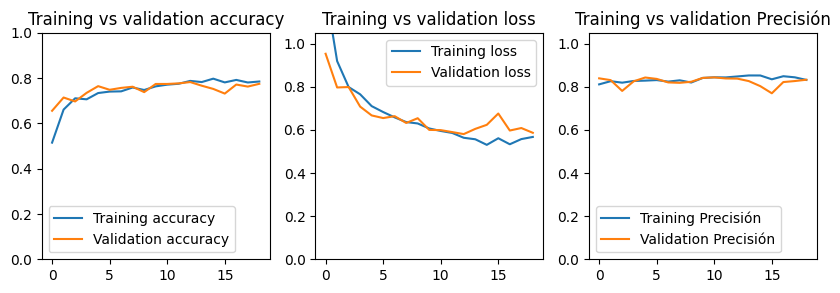

In [ ]:
graph(history_dense)

39/39 [==============================] - 19s 503ms/step


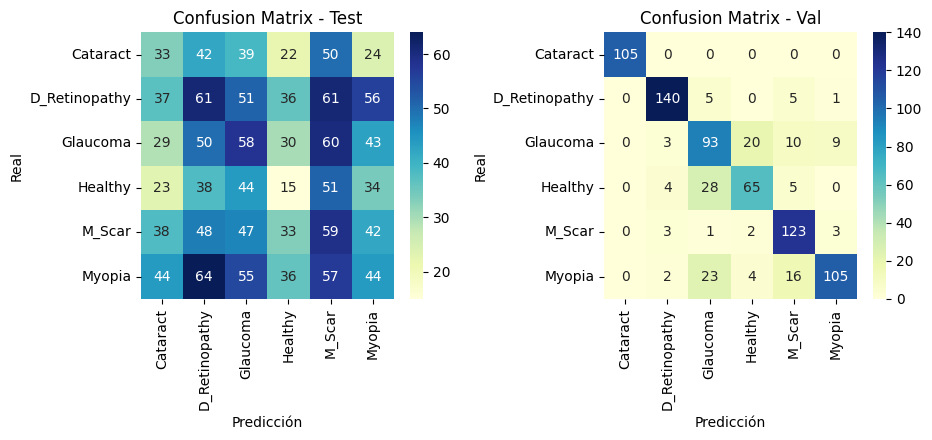

In [ ]:
y_pred_test = model20.predict(test_generator)
y_pred_val = model20.predict(validation_generator)
cf_matrix(y_pred_test, test_generator.classes, y_pred_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.16      0.16      0.16       210
           1       0.20      0.20      0.20       302
           2       0.20      0.21      0.21       270
           3       0.09      0.07      0.08       205
           4       0.17      0.22      0.20       267
           5       0.18      0.15      0.16       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.17      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       0.92      0.93      0.92       151
           2       0.62      0.69      0.65       135
           3       0.71      0.64      0.67       102
           4       0.77      0.93      0.85       132
           5       0.89      0.70      0.78       150

    accuracy                           0.81       775
   macro avg       0.82

## Modelo 19

In [ ]:
from tensorflow.keras.layers import Dropout
# Cargar DenseNet201 sin la capa superior (top) para permitir una nueva capa de salida personalizada
base_model19 = DenseNet201(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para evitar que se modifiquen durante el entrenamiento inicial
for layer in base_model19.layers:
    layer.trainable = False

model19 = Sequential()
model19.add(base_model19)
model19.add(GlobalAveragePooling2D())
model19.add(Dense(2056, activation = 'relu'))
model19.add(Dropout(0.75))
model19.add(Dense(1024, activation = 'relu'))
model19.add(Dense(512, activation = 'relu'))
model19.add(Dropout(0.15))
model19.add(Dense(256, activation = 'relu'))
model19.add(Dense(128, activation = 'relu'))
model19.add(Dense(6, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compilar el modelo
model19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.AUC(name="auc")])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history19 = model19.fit(train_generator, validation_data=test_generator, steps_per_epoch = 150, epochs=25, callbacks=callback)

74836368/74836368 [==============================] - 0s 0us/step
Epoch 1/25
150/150 [==============================] - 141s 773ms/step - loss: 1.4820 - accuracy: 0.3773 - precision: 0.7236 - recall: 0.1146 - auc: 0.7514 - val_loss: 1.0734 - val_accuracy: 0.5592 - val_precision: 0.7010 - val_recall: 0.3681 - val_auc: 0.8840
Epoch 2/25
150/150 [==============================] - 99s 658ms/step - loss: 1.1342 - accuracy: 0.5378 - precision: 0.7706 - recall: 0.3379 - auc: 0.8637 - val_loss: 0.8521 - val_accuracy: 0.6660 - val_precision: 0.8160 - val_recall: 0.4736 - val_auc: 0.9308
Epoch 3/25
150/150 [==============================] - 101s 674ms/step - loss: 1.0024 - accuracy: 0.5917 - precision: 0.7690 - recall: 0.4107 - auc: 0.8966 - val_loss: 0.8041 - val_accuracy: 0.6911 - val_precision: 0.8816 - val_recall: 0.4646 - val_auc: 0.9375
Epoch 4/25
150/150 [==============================] - 103s 686ms/step - loss: 0.9561 - accuracy: 0.6103 - precision: 0.7581 - recall: 0.4387 - auc: 0.9061 -

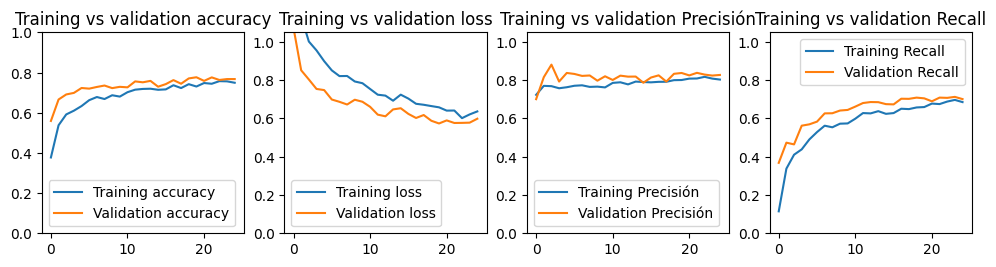

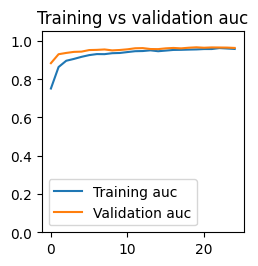

In [ ]:
graph(history19)

39/39 [==============================] - 17s 456ms/step


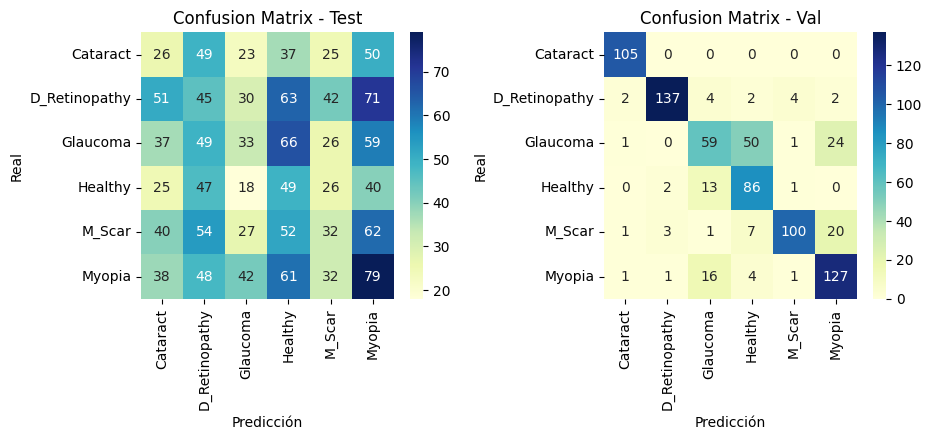

In [ ]:
y_pred19_test = model19.predict(test_generator)
y_pred19_val = model19.predict(validation_generator)
cf_matrix(y_pred19_test, test_generator.classes, y_pred19_val, validation_generator.classes)

In [ ]:
reporte = calcular_metricas_por_clase(y_pred19_test, test_generator.classes)
print(reporte)
reporte = calcular_metricas_por_clase(y_pred19_val, validation_generator.classes)
print(reporte)

              precision    recall  f1-score   support

           0       0.12      0.12      0.12       210
           1       0.15      0.15      0.15       302
           2       0.19      0.12      0.15       270
           3       0.15      0.24      0.18       205
           4       0.17      0.12      0.14       267
           5       0.22      0.26      0.24       300

    accuracy                           0.17      1554
   macro avg       0.17      0.17      0.16      1554
weighted avg       0.17      0.17      0.17      1554

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       105
           1       0.96      0.91      0.93       151
           2       0.63      0.44      0.52       135
           3       0.58      0.84      0.69       102
           4       0.93      0.76      0.84       132
           5       0.73      0.85      0.79       150

    accuracy                           0.79       775
   macro avg       0.80

# Evaluación

Para todos los modelos utilizados se evalua su capacidad de predicción para Entrenamiento, Validación y Prueba

In [ ]:
evaluar_modelo(model1)

Evaluar con Entrenamiento:
272/272 [==============================] - 156s 573ms/step - loss: 0.4565 - accuracy: 0.8181 - precision: 0.8605 - recall: 0.7710 - auc: 0.9788
Evaluar con Validación:
78/78 [==============================] - 28s 357ms/step - loss: 0.5553 - accuracy: 0.7883 - precision: 0.8295 - recall: 0.7516 - auc: 0.9674
Evaluar con Prueba:
39/39 [==============================] - 14s 361ms/step - loss: 0.4465 - accuracy: 0.8155 - precision: 0.8524 - recall: 0.7897 - auc: 0.9793


In [21]:
evaluar_modelo(model4)

Evaluar con Entrenamiento:
272/272 [==============================] - 134s 490ms/step - loss: 0.5753 - accuracy: 0.7754 - precision: 0.8308 - recall: 0.7121 - auc: 0.9661
Evaluar con Validación:
78/78 [==============================] - 25s 318ms/step - loss: 0.5821 - accuracy: 0.7793 - precision: 0.8226 - recall: 0.7220 - auc: 0.9650
Evaluar con Prueba:
39/39 [==============================] - 12s 317ms/step - loss: 0.4708 - accuracy: 0.8077 - precision: 0.8391 - recall: 0.7535 - auc: 0.9774


In [ ]:
evaluar_modelo(model5)

Evaluar con Entrenamiento:
272/272 [==============================] - 163s 598ms/step - loss: 0.5321 - accuracy: 0.7778 - precision: 0.8084 - recall: 0.7377 - auc: 0.9709
Evaluar con Validación:
78/78 [==============================] - 31s 392ms/step - loss: 0.6412 - accuracy: 0.7606 - precision: 0.7906 - recall: 0.7336 - auc: 0.9603
Evaluar con Prueba:
39/39 [==============================] - 14s 367ms/step - loss: 0.4758 - accuracy: 0.8052 - precision: 0.8299 - recall: 0.7806 - auc: 0.9761


In [ ]:
evaluar_modelo(model15)

Evaluar con Entrenamiento:
272/272 [==============================] - 159s 586ms/step - loss: 0.3186 - accuracy: 0.8652 - precision: 0.8875 - recall: 0.8441 - auc: 0.9894
Evaluar con Validación:
78/78 [==============================] - 29s 377ms/step - loss: 0.5470 - accuracy: 0.8050 - precision: 0.8267 - recall: 0.7767 - auc: 0.9681
Evaluar con Prueba:
39/39 [==============================] - 15s 383ms/step - loss: 0.4347 - accuracy: 0.8194 - precision: 0.8358 - recall: 0.7948 - auc: 0.9808


In [ ]:
evaluar_modelo(model16)

Evaluar con Entrenamiento:
272/272 [==============================] - 148s 543ms/step - loss: 0.4136 - accuracy: 0.8365 - precision: 0.8681 - recall: 0.8021 - auc: 0.9821
Evaluar con Validación:
78/78 [==============================] - 27s 350ms/step - loss: 0.5536 - accuracy: 0.7941 - precision: 0.8273 - recall: 0.7677 - auc: 0.9681
Evaluar con Prueba:
39/39 [==============================] - 13s 349ms/step - loss: 0.4455 - accuracy: 0.8026 - precision: 0.8210 - recall: 0.7755 - auc: 0.9793


In [22]:
evaluar_modelo(model6)

Evaluar con Entrenamiento:
272/272 [==============================] - 138s 508ms/step - loss: 0.5877 - accuracy: 0.7739 - precision: 0.8543 - recall: 0.6705 - auc: 0.9655
Evaluar con Validación:
78/78 [==============================] - 24s 305ms/step - loss: 0.6922 - accuracy: 0.7336 - precision: 0.8013 - recall: 0.6486 - auc: 0.9518
Evaluar con Prueba:
39/39 [==============================] - 12s 312ms/step - loss: 0.5902 - accuracy: 0.7768 - precision: 0.8465 - recall: 0.6903 - auc: 0.9639


In [ ]:
evaluar_modelo(model19)

Evaluar con Entrenamiento:
272/272 [==============================] - 134s 493ms/step - loss: 0.5423 - accuracy: 0.7879 - precision: 0.8470 - recall: 0.7163 - auc: 0.9709
Evaluar con Validación:
78/78 [==============================] - 25s 317ms/step - loss: 0.5988 - accuracy: 0.7677 - precision: 0.8276 - recall: 0.7014 - auc: 0.9637
Evaluar con Prueba:
39/39 [==============================] - 12s 307ms/step - loss: 0.4926 - accuracy: 0.7923 - precision: 0.8302 - recall: 0.7316 - auc: 0.9760


In [ ]:
evaluar_modelo(model20)

Evaluar con Entrenamiento:
272/272 [==============================] - 161s 592ms/step - loss: 0.5513 - accuracy: 0.7846 - precision: 0.8449 - recall: 0.7178 - auc: 0.9692
Evaluar con Validación:
78/78 [==============================] - 30s 377ms/step - loss: 0.5864 - accuracy: 0.7748 - precision: 0.8325 - recall: 0.7098 - auc: 0.9647
Evaluar con Prueba:
39/39 [==============================] - 15s 377ms/step - loss: 0.4832 - accuracy: 0.8142 - precision: 0.8695 - recall: 0.7652 - auc: 0.9768
